
# Regressão Linear — Capítulo 2 (Notas de Aula)  
Implementação prática em Jupyter Notebook

**Objetivo:** Este notebook implementa e demonstra, no *dataset* anexado, os tópicos do Capítulo 2 das notas de aula:
1. **Regressão linear analítica** (Seção 2.2.1) — solução pela equação normal.  
2. **Regressão linear iterativa com BGD** (Seção 2.2.2) — *Batch Gradient Descent*.  
3. **Regressão linear iterativa com SGD** — *Stochastic Gradient Descent*.  
4. **Avaliação da qualidade da regressão** (Seção 2.3) — métricas (MSE, RMSE, MAE, R²), análise de resíduos e gráficos.

> Obs.: Para a etapa com gradiente, padronizamos as *features* (média 0, desvio-padrão 1) para melhorar a estabilidade numérica e a convergência.


In [3]:

# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from pathlib import Path
from typing import Tuple, Dict

# Configs do numpy/pandas para reprodutibilidade e display
np.random.seed(42)
pd.set_option('display.max_columns', 50)

DATA_PATH = Path('data_0460_5832.csv')

def train_test_split(X: np.ndarray, y: np.ndarray, test_size: float = 0.2, shuffle: bool = True, seed: int = 42):
    rng = np.random.default_rng(seed)
    n = X.shape[0]
    idx = np.arange(n)
    if shuffle:
        rng.shuffle(idx)
    n_test = int(np.round(n * test_size))
    test_idx = idx[:n_test]
    train_idx = idx[n_test:]
    return X[train_idx], X[test_idx], y[train_idx], y[test_idx]

def add_intercept(X: np.ndarray) -> np.ndarray:
    return np.c_[np.ones((X.shape[0], 1)), X]

def standardize(X: np.ndarray):
    mu = X.mean(axis=0, keepdims=True)
    sigma = X.std(axis=0, ddof=0, keepdims=True)
    sigma = np.where(sigma == 0, 1.0, sigma)  # evita divisão por zero
    Z = (X - mu) / sigma
    return Z, mu, sigma

def destandardize_weights(w_std: np.ndarray, mu: np.ndarray, sigma: np.ndarray) -> np.ndarray:
    # Converte pesos do espaço padronizado (com intercepto) para o espaço original (com intercepto)
    # w_std: (d+1,) para [b_std, w1_std, ..., wd_std]; mu, sigma são (1,d)
    b_std = w_std[0]
    w_no_b = w_std[1:]
    w_orig = w_no_b / sigma.ravel()
    b_orig = b_std - (w_no_b * mu.ravel() / sigma.ravel()).sum()
    return np.r_[b_orig, w_orig]

def mse(y, yhat): return np.mean((y - yhat)**2)
def rmse(y, yhat): return np.sqrt(mse(y, yhat))
def mae(y, yhat): return np.mean(np.abs(y - yhat))
def r2(y, yhat):
    ss_res = np.sum((y - yhat)**2)
    ss_tot = np.sum((y - np.mean(y))**2)
    # Nota: R² pode ser negativo se o modelo for muito ruim
    return 1 - ss_res/ss_tot if ss_tot != 0 else np.nan



## 0. Carregamento e inspeção do *dataset*

- O arquivo fornecido foi detectado em `/mnt/data/data_0460_5832.csv`.
- **Heurística de alvo** (*target*): se existir coluna chamada `y` (ou `target`), usamos essa; caso contrário, assumimos **a última coluna** como variável de saída.


In [4]:

# Carrega o dataset
assert DATA_PATH.exists(), f"Arquivo não encontrado: {DATA_PATH}"
df = pd.read_csv(DATA_PATH)

display(df.head())
print("\nInfo:")
print(df.info())

# Heurística do alvo
candidate_targets = [c for c in df.columns if c.lower() in ('y', 'target')]
if candidate_targets:
    target_col = candidate_targets[0]
else:
    target_col = df.columns[-1]

feature_cols = [c for c in df.columns if c != target_col]
print(f"\nColunas: {list(df.columns)}")
print(f"Alvo escolhido: '{target_col}'")
print(f"Features: {feature_cols}")

# Se existirem colunas não numéricas, tentamos converter/codificar rapidamente
non_numeric = [c for c in feature_cols if not np.issubdtype(df[c].dtype, np.number)]
if non_numeric:
    print(f"Conversão de colunas não numéricas detectadas: {non_numeric}")
    df = pd.get_dummies(df, columns=non_numeric, drop_first=True)
    # Recalcular cols após dummies
    if target_col not in df.columns:
        raise ValueError("Após one-hot, a coluna-alvo desapareceu ou foi renomeada. Ajuste manualmente.")
    feature_cols = [c for c in df.columns if c != target_col]

X = df[feature_cols].to_numpy(dtype=float)
y = df[target_col].to_numpy(dtype=float).ravel()

# Split
X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.2, shuffle=True, seed=42)
print(f"Train shape: X={X_tr.shape}, y={y_tr.shape}; Test shape: X={X_te.shape}, y={y_te.shape}")


Sex  Age  Height  Weight  Shoe number
0  Female   53     154      59           36
1    Male   23     170      56           40
2  Female   23     167      63           37
3    Male   21     178      78           40
4  Female   25     153      58           36


Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 257 entries, 0 to 256
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Sex          257 non-null    object
 1   Age          257 non-null    int64 
 2   Height       257 non-null    int64 
 3   Weight       257 non-null    int64 
 4   Shoe number  257 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 10.2+ KB
None

Colunas: ['Sex', 'Age', 'Height', 'Weight', 'Shoe number']
Alvo escolhido: 'Shoe number'
Features: ['Sex', 'Age', 'Height', 'Weight']
Conversão de colunas não numéricas detectadas: ['Sex']
Train shape: X=(206, 4), y=(206,); Test shape: X=(51, 4), y=(51,)



---
## 1) Regressão Linear Analítica (Seção 2.2.1)

**Equação normal:**  
\[ \mathbf{w} = (\mathbf{X}^\top \mathbf{X})^{-1}\, \mathbf{X}^\top \mathbf{y} \]  
Acrescentamos uma coluna de 1s para o termo de intercepto.

> Na prática, usamos **pseudo-inversa** para estabilidade numérica: \( \mathbf{w} = \operatorname{pinv}(\mathbf{X})\,\mathbf{y} \).


In [5]:

# === Analítica (equação normal) ===
Xtr_bias = add_intercept(X_tr)
Xte_bias = add_intercept(X_te)

# Usando pseudo-inversa para maior estabilidade
w_analytical = np.linalg.pinv(Xtr_bias) @ y_tr

yhat_tr_an = Xtr_bias @ w_analytical
yhat_te_an = Xte_bias @ w_analytical

metrics_an = {
    "Train MSE": mse(y_tr, yhat_tr_an),
    "Train RMSE": rmse(y_tr, yhat_tr_an),
    "Train MAE": mae(y_tr, yhat_tr_an),
    "Train R2": r2(y_tr, yhat_tr_an),
    "Test MSE": mse(y_te, yhat_te_an),
    "Test RMSE": rmse(y_te, yhat_te_an),
    "Test MAE": mae(y_te, yhat_te_an),
    "Test R2": r2(y_te, yhat_te_an),
}
w_analytical, metrics_an


(array([1.54533039e+01, 2.37323910e-03, 1.21229618e-01, 2.62909478e-02,
        2.28053612e+00]),
 {'Train MSE': np.float64(1.694997537846509),
  'Train RMSE': np.float64(1.3019207110444586),
  'Train MAE': np.float64(1.0189672710078381),
  'Train R2': np.float64(0.8227116055870115),
  'Test MSE': np.float64(1.2788341461927937),
  'Test RMSE': np.float64(1.1308554930638988),
  'Test MAE': np.float64(0.8739913677273651),
  'Test R2': np.float64(0.8140306600554927)})


---
## 2) Regressão Linear Iterativa — **Batch Gradient Descent** (Seção 2.2.2)

Minimizamos a perda de erro quadrático médio (MSE):
\[ L(\mathbf{w}) = \frac{1}{2N}\sum_{n=1}^{N} (\hat{y}^{(n)} - y^{(n)})^2, \quad \hat{y} = \mathbf{X}\mathbf{w} \]

**Gradiente:**
\[ \nabla L(\mathbf{w}) = \frac{1}{N}\, \mathbf{X}^\top(\mathbf{X}\mathbf{w} - \mathbf{y}) \]

**Atualização (BGD):**
\[ \mathbf{w} \leftarrow \mathbf{w} - \eta\, \nabla L(\mathbf{w}) \]

Para boa convergência, padronizamos as *features* (mantendo o intercepto separado).


In [6]:

def batch_gradient_descent(X: np.ndarray, y: np.ndarray, lr: float = 0.05, epochs: int = 1000) -> Dict:
    # Padroniza X (sem incluir o intercepto)
    Z, mu, sigma = standardize(X)
    Zb = add_intercept(Z)
    n, d1 = Zb.shape

    w = np.zeros(d1)  # inclui intercepto
    history = {"loss": []}
    for ep in range(epochs):
        yhat = Zb @ w
        grad = (Zb.T @ (yhat - y)) / n  # gradiente da 1/2N * sum(...) = 1/N * X^T(Xw - y)
        w -= lr * grad
        if ep % max(1, epochs//50) == 0 or ep == epochs-1:
            loss = mse(y, yhat) / 2.0
            history["loss"].append(loss)
    # Converte os pesos para o espaço original (para comparação com solução analítica)
    w_orig = destandardize_weights(w, mu, sigma)
    return {"w_std": w, "w_orig": w_orig, "mu": mu, "sigma": sigma, "history": history}

# Treino BGD
bgd = batch_gradient_descent(X_tr, y_tr, lr=0.05, epochs=2000)
w_bgd_orig = bgd["w_orig"]

# Predições no espaço original
yhat_tr_bgd = add_intercept(X_tr) @ w_bgd_orig
yhat_te_bgd = add_intercept(X_te) @ w_bgd_orig

metrics_bgd = {
    "Train MSE": mse(y_tr, yhat_tr_bgd),
    "Train RMSE": rmse(y_tr, yhat_tr_bgd),
    "Train MAE": mae(y_tr, yhat_tr_bgd),
    "Train R2": r2(y_tr, yhat_tr_bgd),
    "Test MSE": mse(y_te, yhat_te_bgd),
    "Test RMSE": rmse(y_te, yhat_te_bgd),
    "Test MAE": mae(y_te, yhat_te_bgd),
    "Test R2": r2(y_te, yhat_te_bgd),
}
w_bgd_orig, metrics_bgd


(array([1.54533039e+01, 2.37323910e-03, 1.21229618e-01, 2.62909478e-02,
        2.28053612e+00]),
 {'Train MSE': np.float64(1.694997537846509),
  'Train RMSE': np.float64(1.3019207110444586),
  'Train MAE': np.float64(1.0189672710078366),
  'Train R2': np.float64(0.8227116055870115),
  'Test MSE': np.float64(1.2788341461927366),
  'Test RMSE': np.float64(1.1308554930638737),
  'Test MAE': np.float64(0.8739913677273499),
  'Test R2': np.float64(0.8140306600555011)})

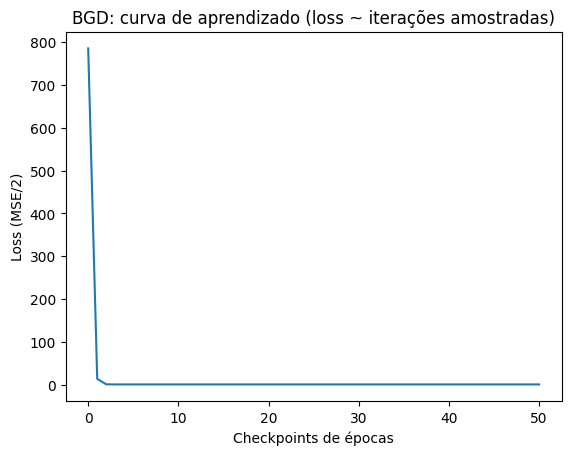

In [ ]:

# Curva de aprendizado (loss vs. iterações) do BGD
plt.figure()
plt.plot(bgd["history"]["loss"])
plt.title("BGD: curva de aprendizado (loss ~ iterações #)")
plt.xlabel("Checkpoints de épocas")
plt.ylabel("Loss (MSE/2)")
plt.show()



---
## 3) Regressão Linear Iterativa — **Stochastic Gradient Descent (SGD)**

Atualizamos os pesos a **cada exemplo** (com *shuffle* por época), o que pode acelerar a convergência inicial em bases maiores.

**Regra (para amostra \(i\)):**
\[ \mathbf{w} \leftarrow \mathbf{w} - \eta \; \nabla L_i(\mathbf{w}) = \mathbf{w} - \eta\, (\hat{y}_i - y_i)\, \mathbf{x}_i \]
(com \(\mathbf{x}_i\) incluindo o intercepto; aqui usamos *features* padronizadas para estabilidade).


In [8]:

def stochastic_gradient_descent(X: np.ndarray, y: np.ndarray, lr: float = 0.05, epochs: int = 50, seed: int = 42) -> Dict:
    rng = np.random.default_rng(seed)
    Z, mu, sigma = standardize(X)
    Zb = add_intercept(Z)
    n, d1 = Zb.shape

    w = np.zeros(d1)
    history = {"loss": []}

    for ep in range(epochs):
        idx = np.arange(n)
        rng.shuffle(idx)
        for i in idx:
            xi = Zb[i]
            yi = y[i]
            yhat_i = xi @ w
            grad_i = (yhat_i - yi) * xi  # gradiente do MSE/2 para exemplo i
            w -= lr * grad_i
        # registra loss médio da época
        yhat = Zb @ w
        history["loss"].append(mse(y, yhat) / 2.0)

    w_orig = destandardize_weights(w, mu, sigma)
    return {"w_std": w, "w_orig": w_orig, "mu": mu, "sigma": sigma, "history": history}

# Treino SGD
sgd = stochastic_gradient_descent(X_tr, y_tr, lr=0.05, epochs=200)
w_sgd_orig = sgd["w_orig"]

yhat_tr_sgd = add_intercept(X_tr) @ w_sgd_orig
yhat_te_sgd = add_intercept(X_te) @ w_sgd_orig

metrics_sgd = {
    "Train MSE": mse(y_tr, yhat_tr_sgd),
    "Train RMSE": rmse(y_tr, yhat_tr_sgd),
    "Train MAE": mae(y_tr, yhat_tr_sgd),
    "Train R2": r2(y_tr, yhat_tr_sgd),
    "Test MSE": mse(y_te, yhat_te_sgd),
    "Test RMSE": rmse(y_te, yhat_te_sgd),
    "Test MAE": mae(y_te, yhat_te_sgd),
    "Test R2": r2(y_te, yhat_te_sgd),
}
w_sgd_orig, metrics_sgd


(array([ 1.40011663,  0.0278625 ,  0.22038036, -0.01046005,  1.07562467]),
 {'Train MSE': np.float64(3.2579785117589974),
  'Train RMSE': np.float64(1.8049871223249758),
  'Train MAE': np.float64(1.16547357965126),
  'Train R2': np.float64(0.6592314935657002),
  'Test MSE': np.float64(1.9620932253532921),
  'Test RMSE': np.float64(1.4007473809910522),
  'Test MAE': np.float64(1.132705210463069),
  'Test R2': np.float64(0.7146704417340985)})

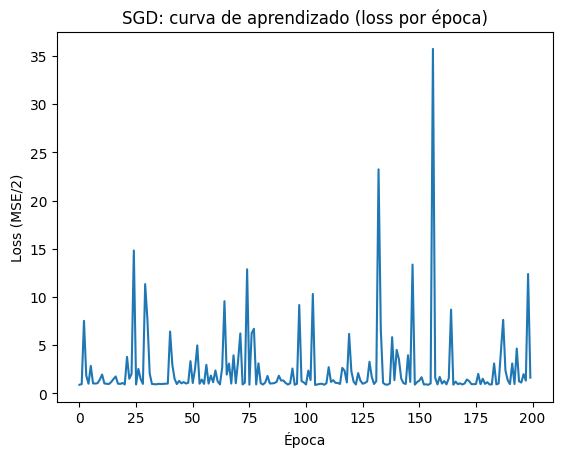

In [9]:

# Curva de aprendizado (loss por época) do SGD
plt.figure()
plt.plot(sgd["history"]["loss"])
plt.title("SGD: curva de aprendizado (loss por época)")
plt.xlabel("Época")
plt.ylabel("Loss (MSE/2)")
plt.show()



---
## 4) Avaliação da Qualidade da Regressão (Seção 2.3)

Métricas principais:
- **MSE**, **RMSE**, **MAE**
- **Coeficiente de determinação (R²)**: \( R^2 = 1 - \frac{\sum (y - \hat{y})^2}{\sum (y - \bar{y})^2} \)

Análises gráficas:
- **Resíduos vs. predições** (busca padrão sem estrutura — homocedasticidade)
- **Histograma de resíduos** (aprox. simétrico, média ~ 0)


In [10]:

# Consolida métricas em uma tabela
rows = []
for name, yhat_tr, yhat_te, m in [
    ("Analítica", Xtr_bias @ w_analytical, Xte_bias @ w_analytical, metrics_an),
    ("BGD", add_intercept(X_tr) @ w_bgd_orig, add_intercept(X_te) @ w_bgd_orig, metrics_bgd),
    ("SGD", add_intercept(X_tr) @ w_sgd_orig, add_intercept(X_te) @ w_sgd_orig, metrics_sgd),
]:
    rows.append({
        "Modelo": name,
        "Train MSE": m["Train MSE"],
        "Train RMSE": m["Train RMSE"],
        "Train MAE": m["Train MAE"],
        "Train R2": m["Train R2"],
        "Test MSE": m["Test MSE"],
        "Test RMSE": m["Test RMSE"],
        "Test MAE": m["Test MAE"],
        "Test R2": m["Test R2"],
    })

metrics_df = pd.DataFrame(rows).set_index("Modelo")
metrics_df.round(6)


Train MSE  Train RMSE  Train MAE  Train R2  Test MSE  Test RMSE  \
Modelo                                                                       
Analítica   1.694998    1.301921   1.018967  0.822712  1.278834   1.130855   
BGD         1.694998    1.301921   1.018967  0.822712  1.278834   1.130855   
SGD         3.257979    1.804987   1.165474  0.659231  1.962093   1.400747   

           Test MAE   Test R2  
Modelo                         
Analítica  0.873991  0.814031  
BGD        0.873991  0.814031  
SGD        1.132705  0.714670

In [ ]:

# Resíduos no conjunto de teste para cada abordagem
res_an = y_te - yhat_te_an
res_bgd = y_te - yhat_te_bgd
res_sgd = y_te - yhat_te_sgd

# Plot: resíduos vs. predições
plt.figure()
plt.scatter(yhat_te_an, res_an, s=12, label="Analítica")
plt.scatter(yhat_te_bgd, res_bgd, s=12, label="BGD")
plt.scatter(yhat_te_sgd, res_sgd, s=12, label="SGD")
plt.axhline(0.0)
plt.title("Resíduos vs. Predições (Teste)")
plt.xlabel("Predição (ŷ)")
plt.ylabel("Resíduo (y - ŷ)")
plt.legend()
plt.show()

# Histograma de resíduos (teste)
plt.figure()
plt.hist(res_an, bins=30, alpha=0.6, label="Analítica")
plt.hist(res_bgd, bins=30, alpha=0.6, label="BGD")
plt.hist(res_sgd, bins=30, alpha=0.6, label="SGD")
plt.title("Distribuição dos Resíduos (Teste)")
plt.xlabel("Resíduo")
plt.ylabel("Frequência")
plt.legend()
plt.show()



### Comentários
- **R² próximo de 1** indica bom ajuste (em relação à variância total de *y*). Valores negativos podem ocorrer se o modelo for pior do que uma previsão constante pela média de *y*.
- **Resíduos** idealmente não apresentam estrutura clara quando plotados contra as predições (indicando linearidade adequada e variância aproximadamente constante).
- Diferenças entre **Analítica, BGD e SGD** tendem a desaparecer com hiperparâmetros bem ajustados; todas minimizam o mesmo objetivo (MSE), mas **BGD/SGD** podem exigir *tuning* de taxa de aprendizado e épocas.
